In [56]:
import numpy as np
import EFIE as solve
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

frequency = 1e6 * 146
omega, wavelength = 2 * np.pi * frequency, light_speed / frequency
incident_field, radius = 10, 3.175e-3
delta_r = wavelength / 100

class yagi:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius

class tree:
    def __init__(self, its, phi, length, f, radius, field):
        self.its = its
        self.phi = phi
        self.length = length
        self.f = f
        self.radius = radius
        self.field = field

basis_functions = 'triangle'
structure_type = 'yagi-uda'
position = np.array([[0.0, 0.0, 0.0], [0.0, wavelength/10, 0.0]])
angle = np.array([[np.pi/2, np.pi/4] , [np.pi/2, np.pi/3]])
length = np.array([wavelength/4, wavelength/4])
source_position = np.array([[0.0, 0.0, 0.0, incident_field]])
radii = np.array([radius, radius])
test_yagi = yagi(position, angle, length, source_position, radii)

In [58]:
import geometry as gm
def calc_field_pattern_new (phi, theta, distance, basis_functions, structure_type, antenna, current, R, delta_r, frequency) :

    omega = 2 * np.pi * frequency
    k = omega / light_speed
    v = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
    aux_v = np.array([1, 0, 0])
    perp_v1 = np.cross(v, aux_v) / np.linalg.norm(np.cross(v, aux_v))
    perp_v2 = np.cross(perp_v1, v) / np.linalg.norm(np.cross(perp_v1, v))

    Radius, num_points = distance, 100
    angles = np.linspace(0, 2 * np.pi, num_points)

    points = np.zeros((num_points, 3))
    for i, angle in enumerate(angles):
        points[i] = Radius * (np.cos(angle) * perp_v1 + np.sin(angle) * perp_v2)

    segments_block, source_segments = gm.antenna_to_segments(structure_type=structure_type, antenna=antenna, basis_functions=basis_functions, delta_r=delta_r)
    
    E = []
    for point in points:
        curr_pos = 0
        E_i = 0
        if basis_functions == 'pulse':
            for m in range(len(segments_block)):
                for i in range(len(segments_block[m])):
                    a_n, tau_n, r_n = segments_block[m][i].radius, segments_block[m][i].tau, segments_block[m][i].position
                    dr_n = delta_r * tau_n
                    rmn = np.linalg.norm(point - r_n)
                    k_vec = (point - r_n) / rmn
                    k_p = k * np.dot(k_vec, dr_n)
                    if k_p == 0:
                        E_i += - 1j * omega * mu0 * current[curr_pos] * delta_r / (4 * np.pi * rmn) * np.exp(-1j * k *rmn)
                    else:
                        E_i += - omega * mu0 * current[curr_pos] * delta_r / (4*np.pi*rmn*k_p) * np.exp(-1j*k*rmn) * np.exp(-1j*k_p/2) * (np.exp(1j*k_p) - 1)
                    curr_pos += 1
        elif basis_functions == 'triangle':
            for m in range(len(segments_block)):
                for i in range(len(segments_block[m])):
                    a_n, tau_n, r_n = segments_block[m][i].radius, segments_block[m][i].tau, segments_block[m][i].position
                    dr_n = delta_r * tau_n
                    rmn = np.linalg.norm(point - r_n)
                    k_vec = (point - r_n) / rmn
                    k_p = k * np.dot(k_vec, dr_n)
                    if k_p == 0:
                        E_i += - 1j * omega * mu0 * current[curr_pos] * delta_r / (2 * np.pi * rmn) * np.exp(-1j * k *rmn)
                    else:
                        E_i += - 1j * omega * mu0 * current[curr_pos] * delta_r / (4*np.pi*rmn*k_p**2) * np.exp(-1j*k*rmn) * np.exp(-1j*k_p) * (2*np.exp(1j*k_p) - np.exp(2j*k_p) - 1)
                    curr_pos += 1
        E.append(E_i)
    E_total = np.abs(E)
    
    return E_total, angles

In [59]:
I,R,_,_,_,_ = solve.calc_current_amplitudes(structure_type,basis_functions,test_yagi,frequency,delta_r)

In [60]:
E,angles = solve.calc_field_pattern(0,0,1e2,basis_functions,structure_type,test_yagi,I,R,delta_r,frequency)
E = 20*np.log10(E)

In [61]:
E_new, angles = calc_field_pattern_new(0,0,1e2,basis_functions,structure_type,test_yagi,I,R,delta_r,frequency)
E_new = 20*np.log10(E_new)

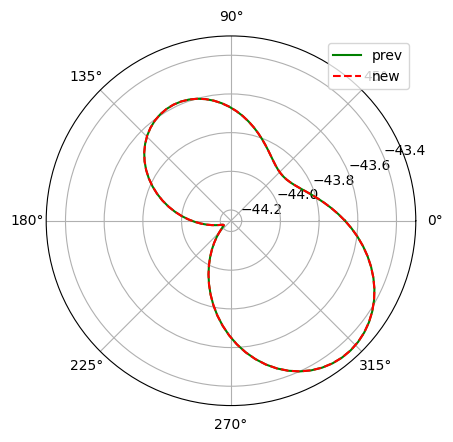

In [62]:
import matplotlib.pyplot as plt 
plt.polar(angles,E, label = 'prev', c = 'g')
plt.polar(angles,E_new, label = 'new', c = 'r', linestyle = '--')
plt.legend()